#**QA with Multimodal RAG: Document Retrieval and Vision Language Models**
---------------------------------------------------

CAS NLP, Module 4 Project, Sandro Wiedmer, 24 Jan'25


#**Problem description**
- Domain-/product-specific QA: RAG document retrieval with several manuals of an X-ray generator product family
- Beside text, information is also included in images and tables
- Use case: Could be helpful for Technical Customer Support, service personnel, customers (OEMs) and end-users, to quickly find information by asking questions in natural language about product usage, debugging, maintenance etc. which by classical text search does not work to the same degree of satisfaction



## Install dependencies


Install the essential libraries



In [ ]:
#!pip install -U -q byaldi pdf2image transformers
!pip install -U -q pdf2image transformers
!pip install -q git+https://github.com/sergiopaniego/byaldi.git@colsmolvlm-support

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 37.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.9/517.9 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

Install poppler-utils for PDF manipulation


In [ ]:
!apt-get update
!sudo apt-get install -y poppler-utils

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,234 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,622 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,228 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,861 kB]
Get:13 https://ppa.launchpadcontent

#**Dataset description**

- “Complex” documents: PDFs with text, tables, images
- Choice of 6 different manuals made available (10…259 pages)
- Only 2 of them connected to RAG, to run with low resources
- Below, queries are chosen in such a way that answers should be found in the connected documents (validation of approach for this use case)


## Load Dataset



In [ ]:
import requests
import os

pdfs = {
    "WebUI_Manual": "https://raw.githubusercontent.com/sandrowiedmer/CAS-NLP-M4-Project/main/Vario_WebUI_Manual_V4.0.0.pdf",
    #"T3_Status_Description": "https://raw.githubusercontent.com/sandrowiedmer/CAS-NLP-M4-Project/main/iVario_T3_Status_Description_V4.0.0.pdf"
    #"Service Manual": "https://raw.githubusercontent.com/sandrowiedmer/CAS-NLP-M4-Project/main/iVario_Service_Manual_V2.5.pdf",
    #"T3 Protocol": "https://raw.githubusercontent.com/sandrowiedmer/CAS-NLP-M4-Project/main/iVario_T3_Protocol_V4.0.0.pdf",
    "T3 Status LED description": "https://raw.githubusercontent.com/sandrowiedmer/CAS-NLP-M4-Project/main/iVario_T3_Status_LED_Description_V4.0.1.pdf"
    #"Series Manual": "https://raw.githubusercontent.com/sandrowiedmer/CAS-NLP-M4-Project/main/iVario_Service_Manual_V2.5.pdf"
}



output_dir = "data"
os.makedirs(output_dir, exist_ok=True)

for name, url in pdfs.items():
    response = requests.get(url)
    pdf_path = os.path.join(output_dir, f"{name}.pdf")

    with open(pdf_path, "wb") as f:
        f.write(response.content)

    print(f"Downloaded {name} to {pdf_path}")

print("Downloaded files:", os.listdir(output_dir))

Downloaded WebUI_Manual to data/WebUI_Manual.pdf
Downloaded T3 Status LED description to data/T3 Status LED description.pdf
Downloaded files: ['WebUI_Manual.pdf', 'T3 Status LED description.pdf']


After downloading the manuals, the PDFs are converted into images. This step is crucial, as it allows the document retrieval model (ColSmolVLM) to process and manipulate the visual content effectively.


In [ ]:
import os
from pdf2image import convert_from_path


def convert_pdfs_to_images(pdf_folder):
    pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith('.pdf')]
    all_images = {}

    for doc_id, pdf_file in enumerate(pdf_files):
        pdf_path = os.path.join(pdf_folder, pdf_file)
        images = convert_from_path(pdf_path)
        all_images[doc_id] = images

    return all_images

all_images = convert_pdfs_to_images("/content/data/")

Visualize a sample to get a sense of how these manuals are presented. This will help to understand the format and layout of the content working with.


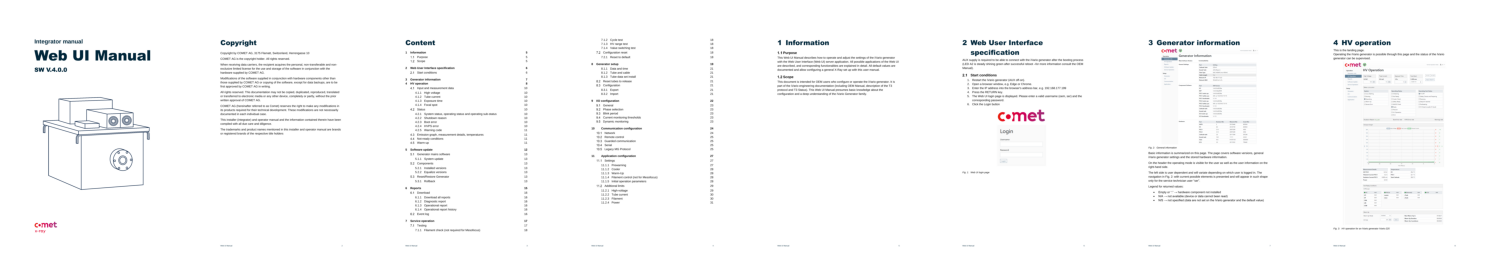

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 8, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img = all_images[0][i]
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

#**Approaches taken - Contrast used approach with other approaches**


Multimodal RAG, built with small vision language models (lightweight models as an actual trend: efficient & low-cost)
- Powerful RAG system capable of enhancing query responses with both text-based documents and visual data
- No complex document processor pipeline needed for extracting data through OCR (optical character recognition)
- ColSmolVLM-alpha: Visual document retriever based on SmolVLM-Instruct with ColBERT strategy (encoder)
- SmolVLM-Instruct - ‘small yet mighty’ Vision Language Model, instruction fine-tuned, QA part (encoder) - input: text and images; output: text; Idefics3 architecture

Links:

https://huggingface.co/learn/cookbook/multimodal_rag_using_document_retrieval_and_smol_vlm

https://huggingface.co/vidore/colsmolvlm-alpha

https://huggingface.co/HuggingFaceTB/SmolVLM-Instruct

https://huggingface.co/HuggingFaceM4/Idefics3-8B-Llama3

https://arxiv.org/pdf/2408.12637



Beside the documentation about ColSmolVLM-Alpha and SmolVLM-Instruct available on HuggingFace, also this page was used as an example how to work with Multimodal RAG based on VLMs (ColPali + Qwen2-VL), and also the structure of the Jupyter file was taken as a baseline: https://huggingface.co/learn/cookbook/multimodal_rag_using_document_retrieval_and_vlms


## Initialize the Multimodal Document Retrieval Model

Now as the dataset is ready, the Document Retrieval Model is initialized, which will be responsible for extracting relevant information from the raw images and providing the appropriate documents based on the queries.

By utilizing this model, we can significantly enhance our conversational capabilities.

For this task, **[Byaldi](https://github.com/AnswerDotAI/byaldi)** is used. The developers describe the library as follows: _"Byaldi is RAGatouille's mini sister project. It is a simple wrapper around the ColPali repository to make it easy to use late-interaction multi-modal models such as ColPALI with a familiar API."_




load the model https://huggingface.co/vidore/colsmolvlm-alpha


In [ ]:
from byaldi import RAGMultiModalModel

docs_retrieval_model = RAGMultiModalModel.from_pretrained("vidore/colsmolvlm-alpha")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.17k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/63.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/72.4M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/489 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.43k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


Index the documents using the document retrieval model by specifying the folder where the PDFs are stored. This will allow the model to process and organize the documents for efficient retrieval based on our queries.


In [ ]:
docs_retrieval_model.index(
    input_path="data/",
    index_name="image_index",
    store_collection_with_index=False,
    overwrite=True
)

Indexing file: data/WebUI_Manual.pdf
Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Added page 13 of document 0 to index.
Added page 14 of document 0 to index.
Added page 15 of document 0 to index.
Added page 16 of document 0 to index.
Added page 17 of document 0 to index.
Added page 18 of document 0 to index.
Added page 19 of document 0 to index.
Added page 20 of document 0 to index.
Added page 21 of document 0 to index.
Added page 22 of document 0 to index.
Added page 23 of document 0 to index.
Added page 24 of document 0 to index.
Added page 25 of document 0 to index.
Added page 26 of docum

{0: 'data/WebUI_Manual.pdf', 1: 'data/T3 Status LED description.pdf'}

## Retrieving Documents with the Document Retrieval Model

Having initialized the document retrieval model, it can now be tested its capabilities by submitting a user query and examining the relevant documents it retrieves.

The model will return the results, ranked directly by their relevance to the query.

In [ ]:
text_query = "What is the minimum kV set value of a mesofocus tube 225MF?"

#results = docs_retrieval_model.search(text_query, k=3)
results = docs_retrieval_model.search(text_query, k=2)
results

[{'doc_id': 0, 'page_num': 10, 'score': 22.625, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 20, 'score': 22.25, 'metadata': {}, 'base64': None}]

Examine the specific documents (images) that the model has retrieved. This will allow to see the visual content that corresponds to our query and understand how the model selects relevant information.


In [ ]:
def get_grouped_images(results, all_images):
    grouped_images = []

    for result in results:
        doc_id = result['doc_id']
        page_num = result['page_num']
        grouped_images.append(all_images[doc_id][page_num - 1]) # page_num are 1-indexed, while doc_ids are 0-indexed. Source https://github.com/AnswerDotAI/byaldi?tab=readme-ov-file#searching

    return grouped_images

grouped_images = get_grouped_images(results, all_images)

Take a closer look at the retrieved documents to understand the information they contain. This examination will help to evaluate the relevance and quality of the retrieved content in relation to the query.


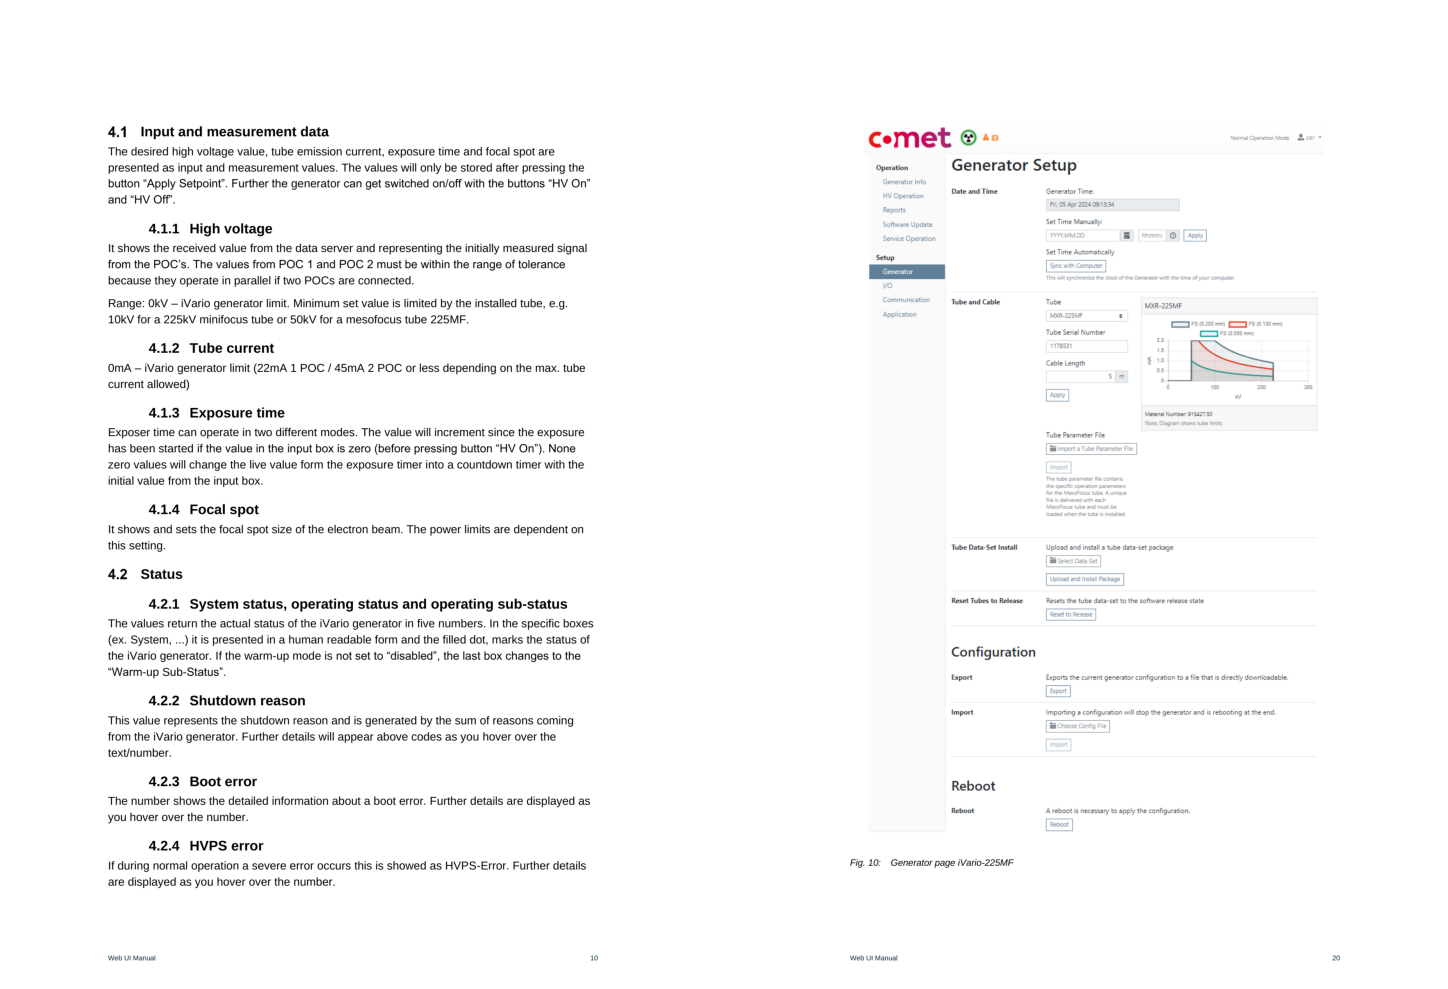

In [ ]:
import matplotlib.pyplot as plt

#fig, axes = plt.subplots(1, 3, figsize=(15, 10))
fig, axes = plt.subplots(1, 2, figsize=(15, 10))


for i, ax in enumerate(axes.flat):
    img = grouped_images[i]
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Initialize the Visual Language Model for Question Answering

Initialize the Visual Language Model (VLM), used for question answering: **[SmolVLM-Instruct](https://huggingface.co/HuggingFaceTB/SmolVLM-Instruct)**.




Before, install flash attention 2, needed for SmolVLM

 https://huggingface.co/docs/transformers/perf_infer_gpu_one#flashattention-2

In [ ]:
pip install flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 52.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.7.3-cp311-cp311-linux_x86_64.whl size=191363917 sha256=b1243e9b86687348a5ab03a073abacdf8e3d5e9e4b7e5326a183f47348c5dfba
  Stored in directory: /root/.cache/pip/wheels/d0/a3/f9/48d2706cb2eac05ec0dc144bf6954fe47bb3c2cd0de280765e
Successfully built flash-attn


Load the model from the pretrained checkpoint and move it to the GPU for optimal performance

In [ ]:
from transformers import Idefics3ForConditionalGeneration, AutoProcessor
import torch


model_id = "HuggingFaceTB/SmolVLM-Instruct"
vl_model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    _attn_implementation="eager",
)
vl_model.eval()

config.json:   0%|          | 0.00/7.32k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.49G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

Idefics3ForConditionalGeneration(
  (model): Idefics3Model(
    (vision_model): Idefics3VisionTransformer(
      (embeddings): Idefics3VisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(729, 1152)
      )
      (encoder): Idefics3Encoder(
        (layers): ModuleList(
          (0-26): 27 x Idefics3EncoderLayer(
            (self_attn): Idefics3VisionAttention(
              (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): Idefics3VisionMLP(
              (activation_fn): PytorchGELUTanh()
              (fc1): Linear(in_

Initialize the VLM processor. The minimum and maximum pixel sizes are defined (optimize the fitting of more images into the GPU memory), ev. not necessary with SmolVLM, it is here since this notebook was initialized with Qwen2-VL (later changed to SmolVLM), where this step is required.


In [ ]:
min_pixels = 224*224
#max_pixels = 1024*1024
max_pixels = 512*512

vl_model_processor = AutoProcessor.from_pretrained(
    "HuggingFaceTB/SmolVLM-Instruct",
    min_pixels=min_pixels,
    max_pixels=max_pixels
)

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


## Assembling the VLM Model and Testing the System

All components are loaded, the system is assembled for testing. First, the chat structure by providing the system with the two (resp. three, or more) retrieved images along with the user query. This step can be customized to fit specific needs, allowing for greater flexibility in how to interact with the model.

Depending on the number of images in grouped images (2 or 3, as an example), use the corresponding chat template

In [ ]:
grouped_images

[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>]

In [ ]:
chat_template = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": grouped_images[0],
            },
            {
                "type": "image",
                "image": grouped_images[1],
            },
            {
                "type": "image",
                "image": grouped_images[2],
            },
            {
                "type": "text",
                "text": text_query
            },
        ],
    }
]

In [ ]:
chat_template = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": grouped_images[0],
            },
            {
                "type": "image",
                "image": grouped_images[1],
            },

            {
                "type": "text",
                "text": text_query
            },
        ],
    }
]

Apply the chat structure:


In [ ]:
text = vl_model_processor.apply_chat_template(chat_template, add_generation_prompt=True)

Process the inputs to ensure they are properly formatted and ready to be used as input for the Visual Language Model (VLM). This step is essential for enabling the model to effectively generate responses based on the provided data.

In [ ]:
inputs = vl_model_processor(
    text=text,
    images=grouped_images,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

Ready to generate the answer. Check how the system utilizes the processed inputs to provide a response based on the user query and the retrieved images.


In [ ]:
generated_ids = vl_model.generate(**inputs, max_new_tokens=500)

Once the model has generated the output, it is postprocessed to generate the final answer.

In [ ]:
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = vl_model_processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

In [ ]:
print(output_text[0])

 The minimum kV set value of a mesofocus tube 225MF is 50kV.


## Assembling It All

Creation of a method that encompasses the entire pipeline, allowing to easily reuse it in future applications.


In [ ]:
def answer_with_multimodal_rag(
    vl_model, docs_retrieval_model, vl_model_processor, grouped_images, text_query, top_k, max_new_tokens):
    results = docs_retrieval_model.search(text_query, k=top_k)
    grouped_images = get_grouped_images(results, all_images)

    chat_template = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": grouped_images[0],
            },
            {
                "type": "image",
                "image": grouped_images[1],
            },

            {
                "type": "text",
                "text": text_query
            },
        ],
    }
]

    # Prepare the inputs
    text = vl_model_processor.apply_chat_template(chat_template, tokenize=False, add_generation_prompt=True)
    #image_inputs, video_inputs = vl_model_processor.apply_chat_template(chat_template)
    inputs = vl_model_processor(
        text=[text],
        images=grouped_images,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    # Generate text from the vl_model
    generated_ids = vl_model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]

    # Decode the generated text
    output_text = vl_model_processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text

#**Results and Evaluations**

**ViDoRe Benchmark (Visual Document Retrieval)**
- Comprehensive Evaluation: ViDoRe Benchmark assesses document retrieval systems across diverse tasks, domains, languages, and settings, including visually rich documents
- Focus on Visual Understanding: It emphasizes the importance of visual content in document retrieval, going beyond traditional text-based approaches
- Real-world Relevance: ViDoRe includes datasets from various real-world applications, making it a valuable tool for evaluating the practical performance of retrieval models
- ColSmolVLM is ranked no. 8 on the ViDoRe  Leaderboard, although one of the smallest VLMs

Links:

https://huggingface.co/blog/smolvlm

https://arxiv.org/pdf/2407.01449

https://huggingface.co/spaces/vidore/vidore-leaderboard



Take a look at how well the complete RAG system operates:

**Manual Result Evaluation**

100% correct answers (6 out of 6 queries):

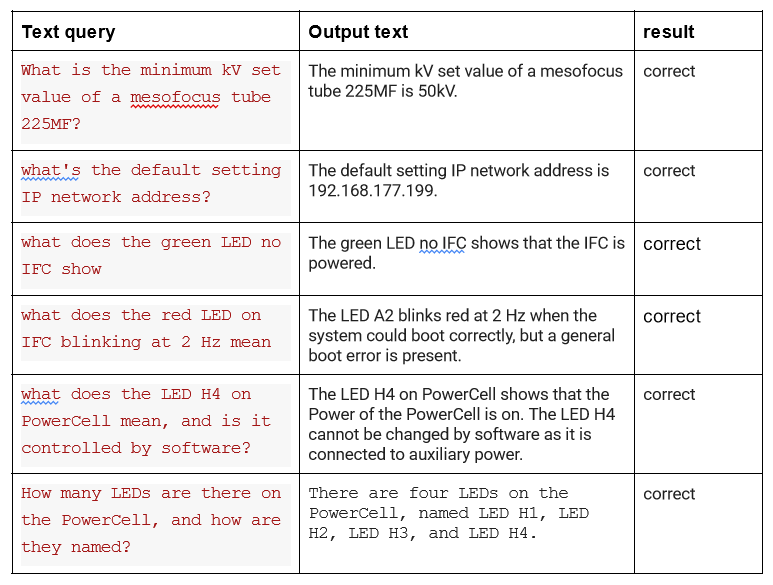




In [ ]:
text_query1 = "What is the minimum kV set value of a mesofocus tube 225MF?"
text_query2 = "what's the default setting IP network address?"
text_query3 = "what does the green LED no IFC show?"
text_query4 = "what does the LED A2 on IFC blinking red at 2 Hz mean?"
text_query5 = "what does the LED H4 on PowerCell mean, and is it controlled by software?"
text_query6 = "How many LEDs are there on the PowerCell, and how are they named?"

In [ ]:
output_text = answer_with_multimodal_rag(
    vl_model=vl_model,
    docs_retrieval_model=docs_retrieval_model,
    vl_model_processor=vl_model_processor,
    grouped_images=grouped_images,
    text_query=text_query6,
    top_k=2,
    max_new_tokens=500
)
print(output_text[0])

 There are four LEDs on the PowerCell, named LED H1, LED H2, LED H3, and LED H4.


#**Discussion**

- Multimodal RAG approach significantly improves information retrieval from PDFs compared to traditional text-based methods: By using visual language models, information presented in tables, images, and diagrams, is available => more comprehensive and accurate answers
- Efficiency: Utilizing small vision language models minimizes computational costs and resource requirements
- Easy-to-use, straightforward setup of Multimodal RAG pipeline using ‘’Smol’ visual language models for retrieval from documents with text, tables, images: Thanks to user-friendly models and helpful documentation available
- Good results with small, lightweight models (in this case) => No further fine-tuning performed, since the available SmolVLM-Instruct model performs well
- As a nice-to-have feature, explainability mechanisms could be expanded: Additionally to showing the page(s) where the information was retrieved, also the specific area on the page(s) could be highlighted (see https://arxiv.org/pdf/2407.01449 as an example)
- Multimodal and vision language models: A lot of potential use cases expected

#**Limitations of Approach**

- Resource Constraints: Although lightweight models used, the focus was on further resources minimization => System and GPU RAM (Google Colab free-tier): Number of document (pages) connected & retrieval relevance ranking top_k = 2
- Potential for getting smaller (even smaller GPU memory footprint): Quantization
- Answer Generation Latency: The current implementation has a relatively high latency (14…15 seconds) for generating answers


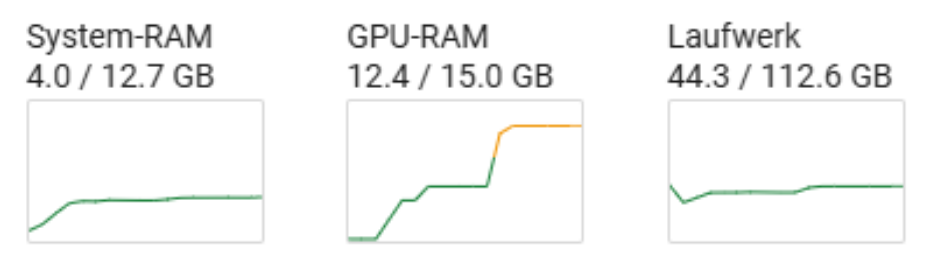